In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.lines as mlines
from IPython.display import display, Latex

## Problem definition

Consider the following constrained optimization problem

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2) = x_1^2 + (x_2-1)^2\\
		& \text{subject to}
		& & g_1^\text{nonlinear}(x_1,x_2) = x_2 - \dfrac{1}{5}x_1^2 \le 0\\
		& & & g_2^\text{linear}(x_1,x_2) = 2x_1 + 3x_2 \le 10\\
		& & & g_3^\text{linear}(x_1,x_2) = -5x_1 - 2x_2 \le -2\\
		& & & g_4^\text{linear}(x_1,x_2) = -2x_1 + 7x_2 \le 8\\
	\end{aligned}
\end{equation*}

We first define the limits over which we want to visualize the function below. Namely, $x_1,x_2\in[-5,5]$.

However, for optimization purposes, we will set the box constraints to be 
$$
	-100 \leq x_1 \leq 100\\
	-100 \leq x_2 \leq 100
$$

## Gradient, Jacobian and coefficient matrix definitions

The Jacobian and gradient for the above problem are given below:

$$
\nabla f(\mathbf{x}) = \begin{bmatrix} 2x_1 \\ 2x_2 - 2 \end{bmatrix}
$$

$$
\nabla \mathbf{g}^\text{nonlinear}(\mathbf{x}) = \begin{bmatrix} -\frac{2}{5}x_1 \\ 1 \end{bmatrix}
$$

The coefficients and solutions vectors for the linear constraints are:
$$
\mathbf{A} = \begin{bmatrix} 2 & 3 \\ -5 & -2 \\ -2 & 7 \end{bmatrix},~\mathbf{b}=\begin{bmatrix} 10 \\ -2 \\ 8 \end{bmatrix}
$$

In [2]:
A = np.array([[2, 3 ],[-5, -2],[-2, 7]]) # coefficient matrix for linear constraints
b = np.array([10,-2,8]) # solution vector for linear constraints

def obj(x):
    """
    function to evaluate objective function
    """
    
    f = x[0]**2 + (x[1]-1)**2
    dfdx = np.array([2*x[0], 2*(x[1]-1)]) # it should an n-element vector

    """
    in case of simulation:
    write x to a text file or as command line arguments
    call/run simulation (either reads the text file or accepts arguments)
    read results from a text file (output by the simulation)
    f = ...
    see examples in 9_dfo
    """

    return f, dfdx

def nonlincon(x):
    """
    function that evaluates general nonlinear constraints
    """

    # evaluate constraints
    g = np.array([x[1] - 0.2*x[0]**2, ]) # it should an m-element vector

    return g

def nonlinconJac(x):
    """
    function that evaluates gradients of general nonlinear constraints
    """

    # evaluate constraint derivatives
    dgdx = np.array([[-0.4*x[0], 1]]) # it should be a mxn array

    return dgdx

# for SLSQP constraints need to be passed to a list of dictionaries (see below)
def lincon(x):
    return (A @ x.reshape((-1,1)) - b.reshape((-1,1))).squeeze()

def linconJac(x):
    return A

We can see that the successive unconstrained minimizers $\mathbf{x}_k^*$ brought use closer to the true constrained minimizer $\mathbf{x}^*$.

No we attempt to solve the optimization problem using several methods from ``scipy.optimize.minimize``. We will use the ``SLSQP`` and the ``trust-constr`` algorithms.

In [3]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

x0 = np.array([-5,20])
n = 2 # variables
m = 1 # nonlinear inequality constraint
bounds = [(-100,100),(-100,100)]

# choose an algorithm
# method = "SLSQP"
method = "trust-constr"

if method == "SLSQP":
    # for SLSQP constraints need to be passed as a list of dictionaries (read the documentation!!)

    constraints = []
    for A_i,b_i in zip(A,b):
        lin_cstr = {
            "type": "ineq", # ‘eq’ for equality, ‘ineq’ for inequality.
            "fun": lambda x : A_i @ x - b_i, # The function defining the constraint.
            "jac": lambda x : A_i, # The Jacobian of fun (only for SLSQP).
        }
        constraints += [lin_cstr]

    # lin_cstr = {
    #     "type": "ineq", # ‘eq’ for equality, ‘ineq’ for inequality.
    #     "fun": lincon, # The function defining the constraint.
    #     "jac": linconJac, # The Jacobian of fun (only for SLSQP).
    # }
    # constraints += [lin_cstr]


    nonlin_cstr = {
        "type": "ineq", # ‘eq’ for equality, ‘ineq’ for inequality.
        "fun": nonlincon, # The function defining the constraint.
        "jac": nonlinconJac, # The Jacobian of fun (only for SLSQP).
    }
    constraints += [nonlin_cstr]

elif method == "trust-constr":
    # for trust-constr constraints is a list of constraint objects (linear or nonlinear)
    lin_cstr = LinearConstraint(A,lb=-np.inf,ub=b)
    nonlin_cstr = NonlinearConstraint(nonlincon,lb=-np.inf,ub=np.zeros(m),jac=nonlinconJac)
    constraints = [lin_cstr,nonlin_cstr]

opt = minimize(obj, x0, args=(), method=method, jac=True, hess=None, hessp=None, 
    bounds=bounds, constraints=constraints, tol=1e-6, callback=None, options=None)

print("===========================")
display(Latex(r"$f(\mathbf{x}^*) = %.4f$" %(opt.fun)))
display(Latex(r"$\mathbf{x}^*$ = $[%.4f~~%.4f]^\mathrm{T}$" %(opt.x[0],opt.x[1])))

if method == "trust-constr":
    # evaluate constraints
    g1_opt = opt.constr[1][0]
    g2_opt = opt.constr[0][0] - b[0]
    g3_opt = opt.constr[0][1] - b[1]
    g4_opt = opt.constr[0][2] - b[2]
    display(Latex(r"$\mathbf{g}(\mathbf{x}^*)$ = $[%.4f~~%.4f~~%.4f~~%.4f]^\mathrm{T}$" %(g1_opt,g2_opt,g3_opt,g4_opt)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Problem visualization
Let use visualize the optimization problem and the obtained solution

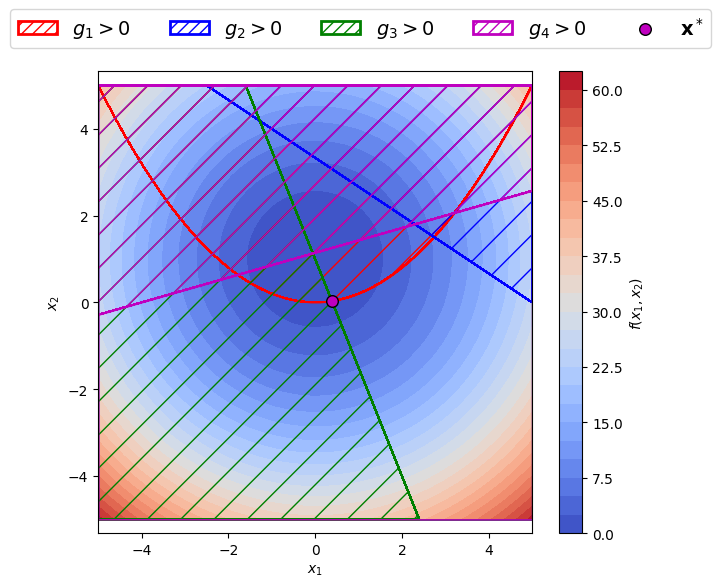

In [4]:
# Problem definition
lb = [-5, -5]
ub = [5, 5]

# for creating hatched constraints
def constraint_color(cf,color):
    # https://github.com/matplotlib/matplotlib/issues/2789/#issuecomment-604599060
    for i, collection in enumerate(cf.collections):
        collection.set_edgecolor(color)

n = 50
x1 = np.linspace(lb[0],ub[0],n)
x2 = np.linspace(lb[0],ub[0],n)
X1, X2 = np.meshgrid(x1,x2)
F = X1**2+(X2-1)**2
G1 = X2 - (X1**2)/5
G2 = 2*X1 + 3*X2 - 10
G3 = -5*X1 - 2*X2 + 2
G4 = -2*X1 + 7*X2 - 8

fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contourf(X1, X2, F,cmap="coolwarm",levels=25,zorder=-1)
fig.colorbar(cf, ax=ax, orientation="vertical", label=r"$f(x_1,x_2)$")

handles = []; labels = []
# Constraints
colors = ["r","b","g","m"]

for i,(color,G) in enumerate(zip(colors,[G1,G2,G3,G4])):
    cf = ax.contourf(X1, X2, G, levels=[-200, 0, 200], colors="none",hatches=[None, "/"],extend="lower")
    constraint_color(cf,color)
    a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor=color, facecolor="none", fill="None", hatch="///")
    handles += [a_hatch]
    labels += [r"$g_%i>0$" %(i+1)]

hopt = ax.scatter([opt.x[0],], [opt.x[1],], s = 70, marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
handles += [hopt]
labels += [r"$\mathbf{x}^*$"]

# legend
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis("equal")
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[0],ub[0]))
lx = fig.legend(handles, labels, loc="upper center", ncol=5, fontsize = 14)
# fig.savefig("nlp_example.pdf",bbox_inches="tight")
plt.show()
